In [1]:
# import seaborn
import seaborn as sns
import pandas as pd
import numpy as np


# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})

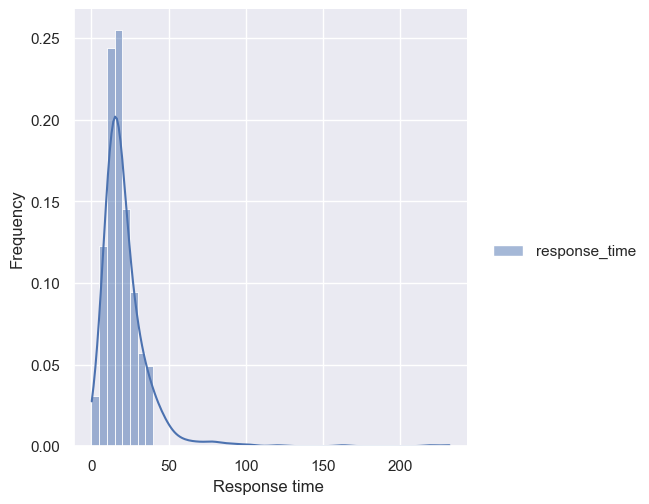

In [53]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

df = pd.read_csv("C:/Users/erikm/Documents/Master/ambulance-optimization/src/main/resources/data/incidents.csv")

def convert(timestamp):
    year = int(timestamp[0:4])
    month = int(timestamp[5:7])
    day = int(timestamp[8:10])
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:19])
    time = datetime(year, month, day, hour, minute, second)
    return time

start = datetime(2017, 8, 7, 0, 0, 0)
end = datetime(2017, 8, 14, 0, 0, 0)

rows = []
for incident in df.values:
    try:
        time = convert(incident[0])
        urgency = incident[3]
        if start < time < end and urgency == "H":
            arrival = convert(incident[6])
            delta = arrival - time
            response = {"time": time, "response_time": delta.seconds/60}
            rows.append(response)
    except:
        continue

response_times = pd.DataFrame(rows)    

ax = sns.displot(response_times, kde=True, color='red')
ax.set(xlabel='Response time ', ylabel='Frequency')

In [17]:
df = pd.read_csv("proprietary_data/cleaned_data.csv", encoding='utf-8', escapechar='\\')

df[df["hastegrad"] == 'V1'] = 'V'
df[df["hastegrad"] == 'V2'] = 'V'
df = df[df['hastegrad'].notna()]

urgency = df["hastegrad"]
urgency = urgency.sort_values()


C:\Users\erikm\AppData\Local\Temp\ipykernel_6812\584488271.py:1: DtypeWarning: Columns (8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("proprietary_data/cleaned_data.csv", encoding='utf-8', escapechar='\\')


[Text(0.5, 0, 'Distribution '), Text(0, 0.5, 'Frequency')]

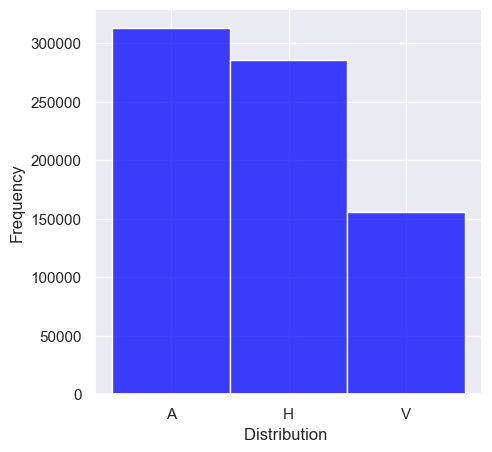

In [18]:
ax = sns.histplot(urgency, kde=False, color='blue')
ax.set(xlabel='Distribution ', ylabel='Frequency')

[Text(0.5, 0, 'Distribution '), Text(0, 0.5, 'Frequency')]

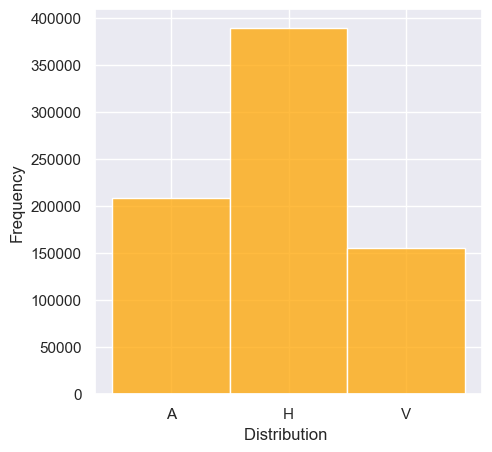

In [61]:
urgency_preset = []
for u in urgency:
    if u == 'A':
        u = np.random.choice(['A', 'H'], p=[2/3, 1/3])
    urgency_preset.append(u)

urgency_preset.sort()
urgency_preset = pd.Series(urgency_preset)

ax = sns.histplot(urgency_preset, kde=False, color='orange')
ax.set(xlabel='Distribution ', ylabel='Frequency')

[Text(0.5, 0, 'Distribution '), Text(0, 0.5, 'Frequency')]

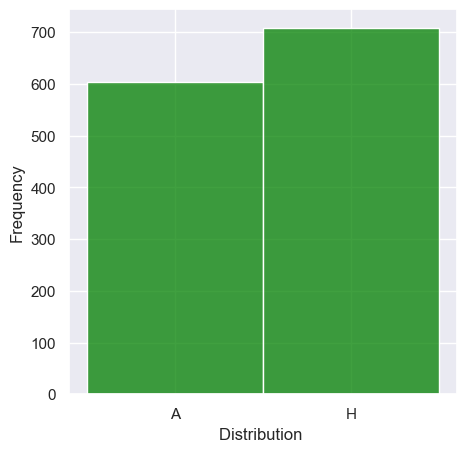

In [36]:
df_sim = pd.read_csv("C:/Users/erikm/Documents/Master/ambulance-optimization/output/simulation/urgency_experiment_5_runs/urgency_incidents.csv")

urgency_sim = df_sim["urgency"]
urgency_sim = urgency_sim.sort_values()

ax = sns.histplot(urgency_sim, kde=False, color='green')
ax.set(xlabel='Distribution ', ylabel='Frequency')


[Text(0.5, 0, 'Distribution '), Text(0, 0.5, 'Frequency')]

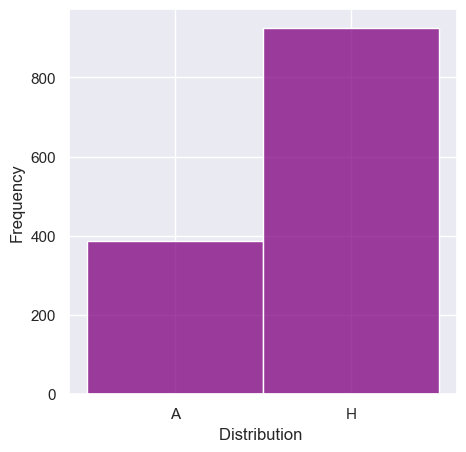

In [102]:
urgency_sim_preset = []
for u in urgency_sim:
    if u == 'A':
        u = np.random.choice(['A', 'H'], p=[2/3, 1/3])
    urgency_sim_preset.append(u)

urgency_sim_preset.sort()
urgency_sim_preset = pd.Series(urgency_sim_preset)

ax = sns.histplot(urgency_sim_preset, kde=False, color='purple')
ax.set(xlabel='Distribution ', ylabel='Frequency')

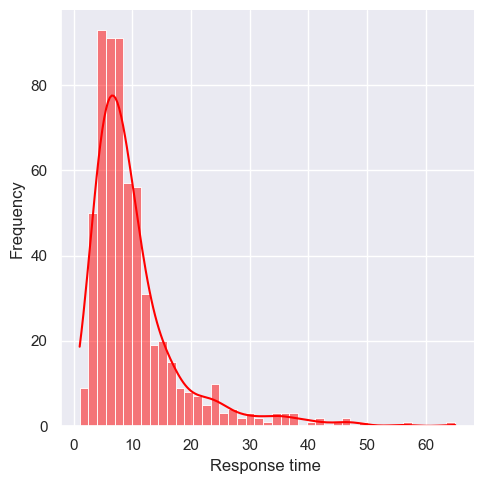

In [40]:
df_sim_A = df_sim[df_sim["urgency"] == "A"]

response_sim_A = df_sim_A["pop_prop_response"] / 60

ax = sns.displot(response_sim_A, kde=True, color='red')
ax.set(xlabel='Response time ', ylabel='Frequency')

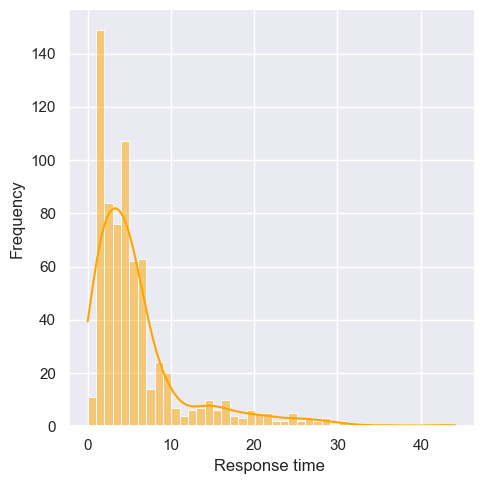

In [134]:
df_sim_H = df_sim[df_sim["urgency"] == "H"]

response_sim_H = df_sim_H["pop_prop_response"] / 60

ax = sns.displot(response_sim_H, kde=True, color='orange')
ax.set(xlabel='Response time ', ylabel='Frequency')

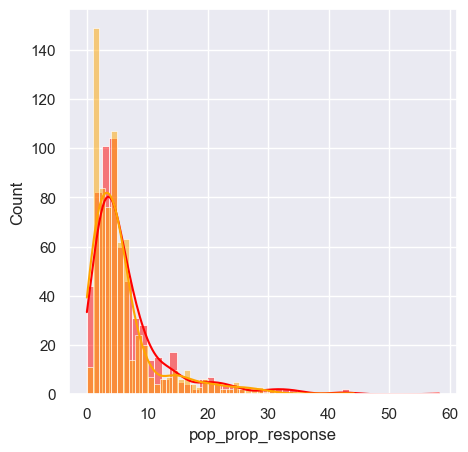

In [135]:
import matplotlib.pyplot as plt

sns.histplot(response_sim_A, kde=True, color='red')
sns.histplot(response_sim_H, kde=True, color='orange')
plt.show()

(0.0, 200.0)

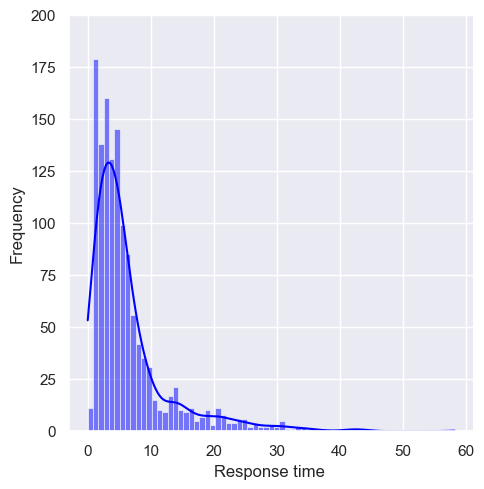

In [43]:
df_sim = pd.read_csv("C:/Users/erikm/Documents/Master/ambulance-optimization/output/simulation/urgency_incidents.csv")

df_sim_A = df_sim[df_sim["urgency"] == "A"]

response_sim_A = df_sim["pop_prop_response"] / 60

ax = sns.displot(response_sim_A, kde=True, color='blue')
ax.set(xlabel='Response time ', ylabel='Frequency')
plt.ylim(0, 200)


(0.0, 160.0)

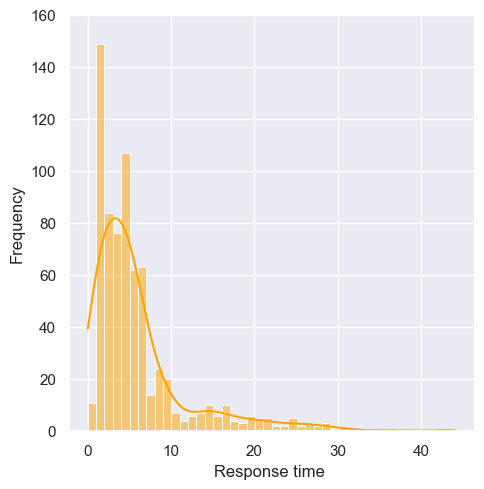

In [15]:
df_sim_H = df_sim[df_sim["urgency"] == "H"]

response_sim_H = df_sim_H["pop_prop_response"] / 60

ax = sns.displot(response_sim_H, kde=True, color='orange')
ax.set(xlabel='Response time ', ylabel='Frequency')
plt.ylim(0, 160)

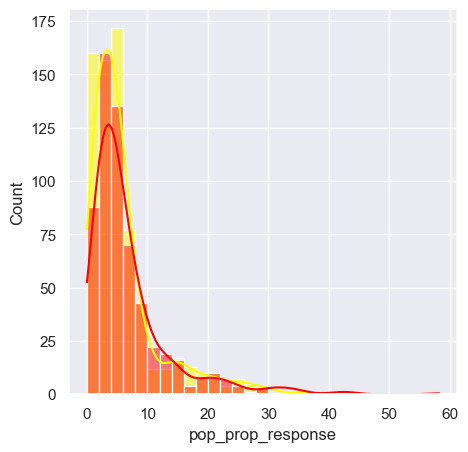

In [132]:
sns.histplot(response_sim_H, bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], kde=True, color='yellow')
sns.histplot(response_sim_A, bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], kde=True, color='red')

plt.show()

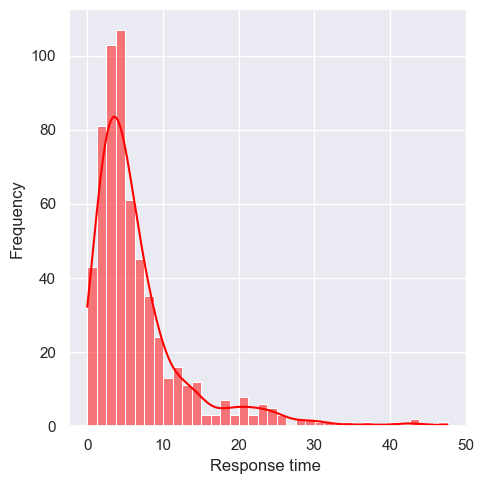

In [139]:
df_sim = pd.read_csv("C:/Users/erikm/Documents/Master/ambulance-optimization/output/simulation/dispatch_urgency_incidents.csv")

df_sim_A = df_sim[df_sim["urgency"] == "A"]

response_sim_A = df_sim_A["pop_prop_response"] / 60

ax = sns.displot(response_sim_A, kde=True, color='red')
ax.set(xlabel='Response time ', ylabel='Frequency')


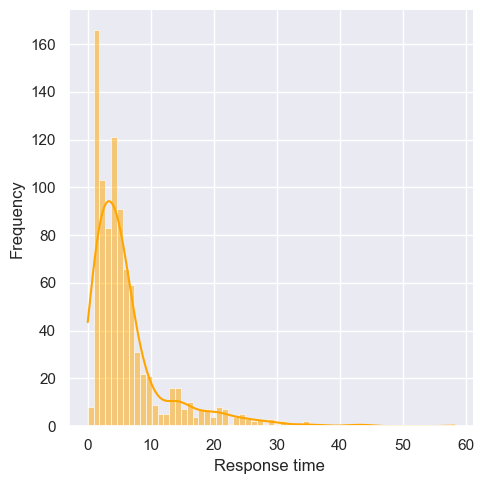

In [137]:
df_sim_H = df_sim[df_sim["urgency"] == "H"]

response_sim_H = df_sim_H["pop_prop_response"] / 60

ax = sns.displot(response_sim_H, kde=True, color='orange')
ax.set(xlabel='Response time ', ylabel='Frequency')

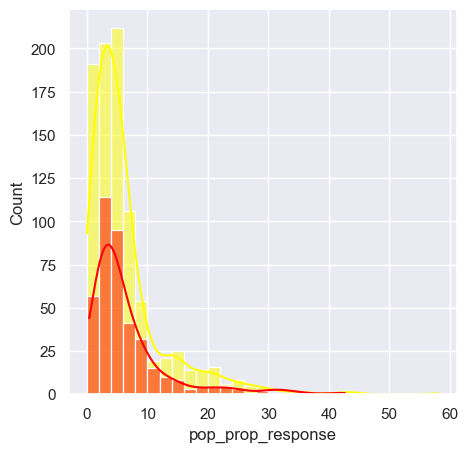

In [138]:
sns.histplot(response_sim_H, bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], kde=True, color='yellow')
sns.histplot(response_sim_A, bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], kde=True, color='red')

plt.show()